# Лабораторная работа #4 (Муравьиный алгоритм)

### Зависимости

In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

### Генерация случайных координат точек и дорог между ними

In [2]:
'''
Генерация случайных координат точек в трехмерном пространстве.
'''
def generate_random_points(
    n: int,
    x_range: Tuple[float, float] = (0, 100),
    y_range: Tuple[float, float] = (0, 100),
    z_range: Tuple[float, float] = (0, 100)
) -> np.ndarray:
    points: np.ndarray = np.random.uniform(low=[x_range[0], y_range[0], z_range[0]],
                               high=[x_range[1], y_range[1], z_range[1]],
                               size=(n, 3))
    return points

'''
Создание графа на основе координат точек.
'''
def generate_graph(points: np.ndarray, directed: bool = False) -> nx.Graph:
    graph = nx.DiGraph() if directed else nx.Graph()
    for i, (x, y, z) in enumerate(points):
        graph.add_node(i, pos=(x, y, z))
    
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            dist = np.linalg.norm(points[i] - points[j])
            graph.add_edge(i, j, weight=dist)
            if not directed:
                graph.add_edge(j, i, weight=dist)
    
    return graph

### Реализация муравьиного алгоритма

In [3]:
'''
Получить длину пути из одной вершины в другую.
'''
WEIGHT_PROP = "weight"

'''
Муравьиный алгоритм для решения задачи коммивояжера.
'''
def ant_colony_optimization(
    graph: nx.Graph,
    n_ants: int = 10,
    n_iterations: int = 100,
    alpha: float = 1,
    beta: float = 2,
    rho: float = 0.5,
    Q: float = 100
) -> Tuple[List[int], float]:
    n = len(graph.nodes)
    pheromone = np.ones((n, n))
    best_path = None
    best_path_length = float('inf')
    
    for iteration in range(n_iterations):
        paths = []
        path_lengths = []
        
        for ant in range(n_ants):
            visited = [False] * n
            current_node = random.choice(list(graph.nodes))
            path = [current_node]
            path_length = 0
            
            for _ in range(n - 1):
                visited[current_node] = True
                next_node = select_next_node(graph, current_node, visited, pheromone, alpha, beta)
                path.append(next_node)
                path_length += graph[current_node][next_node][WEIGHT_PROP]
                current_node = next_node
            
            path.append(path[0])  # Вернуться в начальную точку
            path_length += graph[current_node][path[0]][WEIGHT_PROP]
            paths.append(path)
            path_lengths.append(path_length)
            
            if path_length < best_path_length:
                best_path = path
                best_path_length = path_length
        
        update_pheromone(pheromone, paths, path_lengths, rho, Q)
    
    return best_path, best_path_length

'''
Выбор следующей вершины на основе феромонов и расстояния.
'''
def select_next_node(
    graph: nx.Graph,
    current_node: int,
    visited: List[bool],
    pheromone: np.ndarray,
    alpha: float,
    beta: float
) -> Optional[int]:
    unvisited_nodes = [node for node in graph.nodes if not visited[node]]
    if not unvisited_nodes:
        return None
    
    probabilities = []
    for node in unvisited_nodes:
        pheromone_value = pheromone[current_node][node]
        distance = graph[current_node][node][WEIGHT_PROP]
        probability = (pheromone_value ** alpha) * ((1 / distance) ** beta)
        probabilities.append(probability)
    
    probabilities = np.array(probabilities) / sum(probabilities)
    next_node = np.random.choice(unvisited_nodes, p=probabilities)
    return next_node

'''
Обновление феромонов на основе пройденных путей.
'''
def update_pheromone(
    pheromone: np.ndarray,
    paths: List[List[int]],
    path_lengths: List[float],
    rho: float,
    Q: float
) -> None:
    pheromone *= (1 - rho)
    for path, path_length in zip(paths, path_lengths):
        for i in range(len(path) - 1):
            pheromone[path[i]][path[i + 1]] += Q / path_length

### Визуализация полученного пути

In [4]:
'''
Визуализация пути в трехмерном пространстве.
'''
def visualize_path(points: np.ndarray, path: List[int]) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Отображение точек
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='red', marker='o')
    
    # Отображение пути
    path_points = points[path]
    ax.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], c='blue', marker='o')
    
    plt.show()

Число точек: 10, оптимальная длина пути: 449.2712788360115


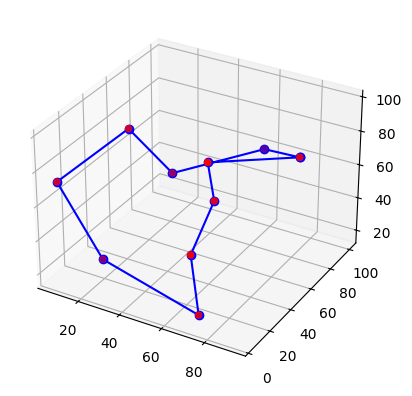

Число точек: 200, оптимальная длина пути: 3065.9730242278097


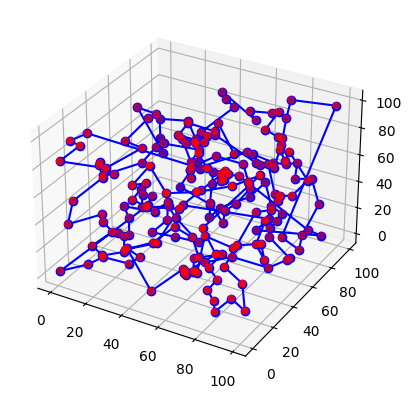

Число точек: 500, оптимальная длина пути: 5741.97226135657


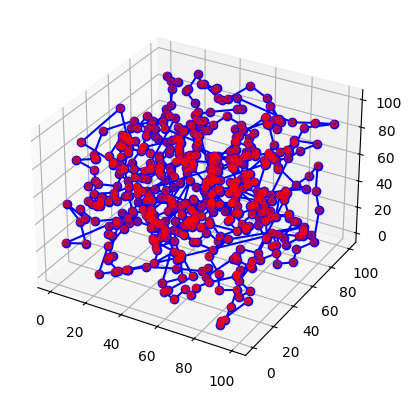

Число точек: 1000, оптимальная длина пути: 9953.641361205753


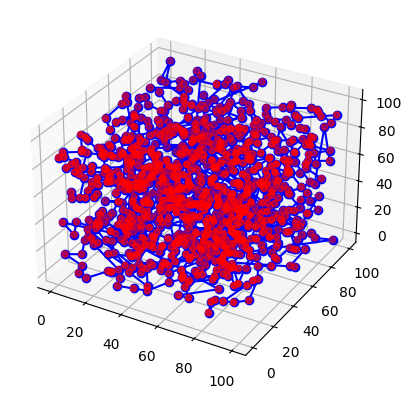

In [5]:
point_tests: List[int] = [10, 200, 500, 1000]
for n in point_tests:
    points = generate_random_points(n)
    graph = generate_graph(points, directed=False)
    best_path, best_path_length = ant_colony_optimization(graph)
    print(f"Число точек: {n}, оптимальная длина пути: {best_path_length}")
    visualize_path(points, best_path)